In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!wget https://cdn.pixabay.com/photo/2017/07/31/07/58/dog-2556796_960_720.jpg -O _data/sample_image.jpg

--2021-05-06 18:53:19--  https://cdn.pixabay.com/photo/2017/07/31/07/58/dog-2556796_960_720.jpg
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:15b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



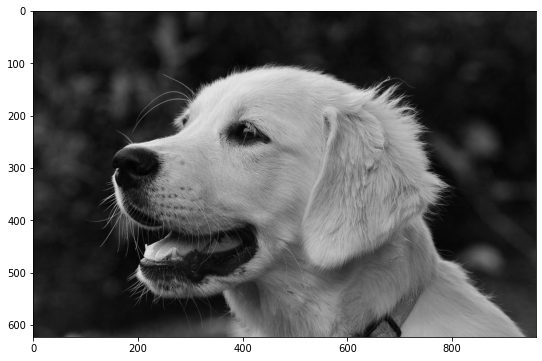

In [3]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from jax import numpy as jnp

img = Image.open("./_data/sample_image.jpg")
img = np.array(img)[:,:,0].astype(np.float32)
img = img[:img.shape[1],:]/255. - 0.5

plt.figure(figsize=(12,6))
plt.imshow(img, cmap="gray")
plt.show()

In [4]:
from jwave import geometry

In [5]:
# Create grid object
N = img.shape
dx = tuple([1 for _ in N])
grid = geometry.kGrid.make_grid(N,dx)

In [6]:
print(grid)

kGrid Object:
------------
N: (623, 960)
dx: (1, 1)
cell_area: 1
space_axis: ['(s) (623,)', '(s) (960,)']
k_vec: [['(s) (623,)', '(s) (960,)'], 'None', 'None']
k_with_kspaceop: None



In [7]:
from jwave.spectral import derivative_init

In [8]:
Dx, grid = derivative_init(img, grid, axis=0)

In [9]:
print(grid)

kGrid Object:
------------
N: (623, 960)
dx: (1, 1)
cell_area: 1
space_axis: ['(s) (623,)', '(s) (960,)']
k_vec: [['(s) (623,)', '(s) (960,)'], 'None', 'None']
k_with_kspaceop: None



In [10]:
Dx_img = Dx(img, grid, degree=1.)

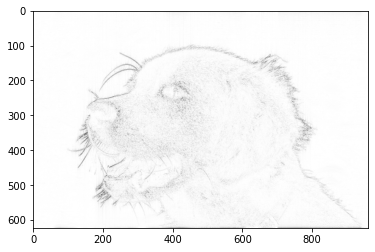

In [11]:
plt.imshow(jnp.abs(Dx_img), cmap="binary")

In [12]:
Dy, grid = derivative_init(img, grid, axis=1)

In [13]:
Dy_img = Dy(img, grid, 1.)

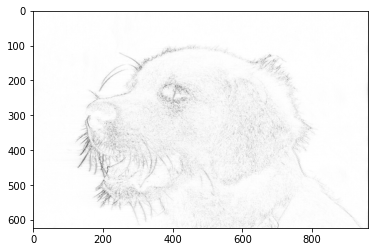

In [14]:
plt.imshow(jnp.abs(Dy_img), cmap="binary")

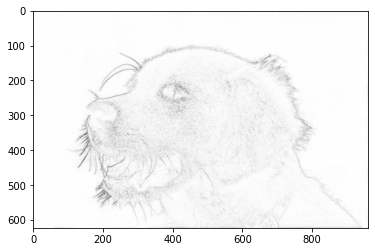

In [15]:
edges = jnp.abs(Dx_img) + jnp.abs(Dy_img)
plt.imshow(edges, cmap="binary")

In [16]:
%%timeit 
Dx_img = Dx(img, grid, 1.)

4.42 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
import jax
Dx_fast = jax.jit(lambda x,y: Dx(x,y,1.))

In [18]:
%%timeit 
Dx_fast(img, grid).block_until_ready()

553 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
%%timeit 
Dy_img = Dy(img, grid, 1.)

3.89 ms ± 55.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
import jax
Dy_fast = jax.jit(lambda x,y: Dy(x,y,1.))

In [21]:
%%timeit 
Dy_fast(img, grid).block_until_ready()

407 µs ± 8.27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
from jwave.geometry import Staggered
Dx, grid = derivative_init(img, grid, axis=0, staggered=Staggered.FORWARD)

In [23]:
print(grid)

kGrid Object:
------------
N: (623, 960)
dx: (1, 1)
cell_area: 1
space_axis: ['(s) (623,)', '(s) (960,)']
k_vec: [['(s) (623,)', '(s) (960,)'], ['(s) (623,)', '(s) (960,)'], ['(s) (623,)', '(s) (960,)']]
k_with_kspaceop: None



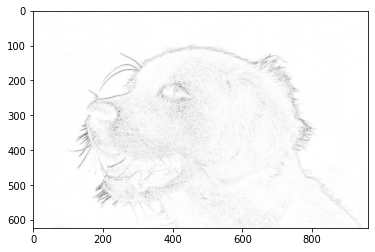

In [24]:
Dx_img = Dx(img, grid, 1.)
plt.imshow(jnp.abs(Dx_img), cmap="binary")

In [25]:
grid = grid.apply_kspace_operator(c_ref=1., dt=0.1)

In [26]:
print(grid)

kGrid Object:
------------
N: (623, 960)
dx: (1, 1)
cell_area: 1
space_axis: ['(s) (623,)', '(s) (960,)']
k_vec: [['(s) (623,)', '(s) (960,)'], ['(s) (623,)', '(s) (960,)'], ['(s) (623,)', '(s) (960,)']]
k_with_kspaceop: ['(s) (2, 623, 960)', '(s) (2, 623, 960)', '(s) (2, 623, 960)']



In [27]:
Dx_ksp, grid = derivative_init(img, grid, axis=0, staggered=Staggered.FORWARD, kspace_op=True)

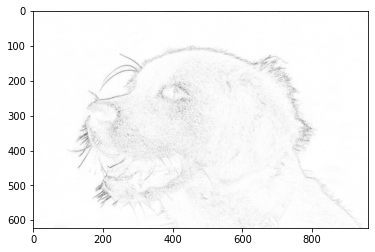

In [28]:
Dx_img = Dx_ksp(img, grid)
plt.imshow(jnp.abs(Dx_img), cmap="binary")

In [29]:
# Multiple degrees of derivatives with vmap (saves FFTs)
D_two_orders = jax.jit(jax.vmap(Dx, in_axes=(None, None, 0)))

In [30]:
D_maps = D_two_orders(img, grid, jnp.array([1.0, 2.0]))

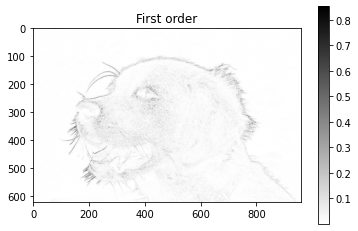

In [31]:
plt.imshow(jnp.abs(D_maps[0]), cmap="binary")
plt.title("First order")
plt.colorbar()

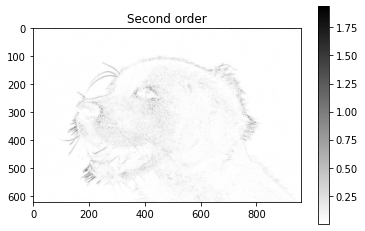

In [32]:
plt.imshow(jnp.abs(D_maps[1]), cmap="binary")
plt.title("Second order")
plt.colorbar()